In [1]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import astropy.convolution



In [16]:
x_start = 1700
x_end = 1900

y_start = 1500
y_end = 1700

data = fits.getdata('/Users/nasserm/Documents/vscode/lsstda/waldointhesky/waldo_plus_stars_less.fits')


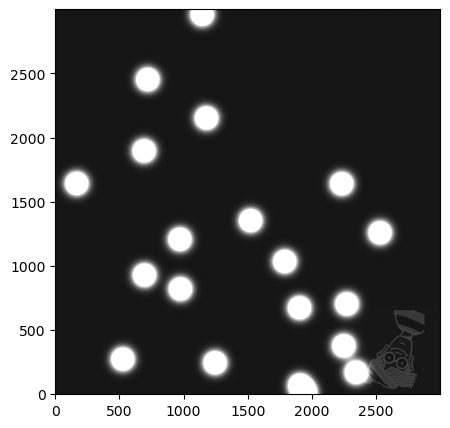

In [17]:
plt.figure(figsize=(5,5))
vmin, vmax = np.percentile(data, [30, 75])
plt.imshow(data, vmin = 0, vmax = 1200, origin='lower', cmap='gray')

In [18]:
def find_peaks(image, threshold):
    peak_x_values = []
    peak_y_values = []
    for j in range(np.shape(image)[1]):  # x
        for i in range(np.shape(image)[0]):  # y
            try:
                if image[i, j] > threshold:
                    point = image[i, j]
                    north = image[i-1, j]
                    south = image[i+1, j]
                    east = image[i, j+1]
                    west = image[i, j-1]
                    ne = image[i-1, j+1]
                    nw = image[i-1, j-1]
                    se = image[i+1, j+1]
                    sw = image[i+1, j-1]
                    max_ = np.argmax(np.array([point, np.mean([north, south, east, west, ne, nw, se, sw])]))
                    if max_ == 0:
                        peak_x_values.append(j)
                        peak_y_values.append(i)
            except IndexError:
                pass  # skip edges
    return np.array(peak_x_values), np.array(peak_y_values)

In [19]:
from astropy.convolution import convolve, convolve_fft
from astropy.convolution import Gaussian2DKernel

import centroid_tools


peak_x_values, peak_y_values, convolved_image = centroid_tools.convolve_peaks(data, threshold = 1000, std=2)

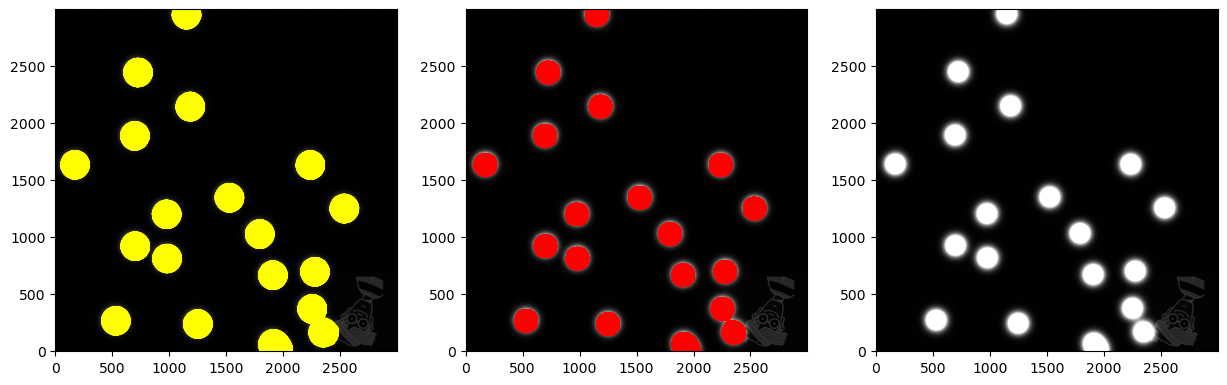

In [20]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
vmin, vmax = np.percentile(data, [25, 95])
plt.imshow(convolved_image, vmin = vmin, vmax = vmax, cmap='gray', origin='lower')
plt.scatter(peak_x_values, peak_y_values, s = 20, color = 'yellow')

plt.subplot(1,3,2)
plt.imshow(data, vmin = vmin, vmax = vmax, cmap='gray', origin='lower')
plt.scatter(peak_x_values, peak_y_values, s = 1, color = 'red')

plt.subplot(1,3,3)
plt.imshow(convolved_image, vmin = vmin, vmax = vmax, cmap='gray', origin='lower')

In [22]:
import numpy as np
from sklearn.cluster import KMeans

# your data
points = np.column_stack((peak_x_values, peak_y_values))

k = 20
kmeans = KMeans(n_clusters=k, random_state=14).fit(points)

centers = kmeans.cluster_centers_

/opt/anaconda3/envs/DSFP/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


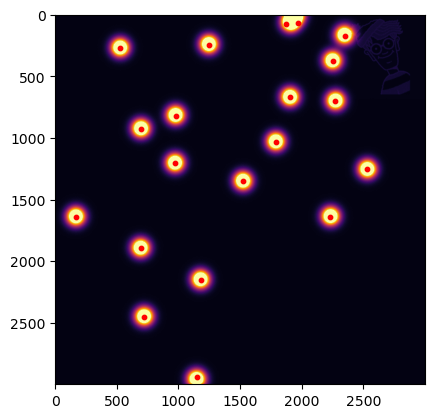

In [23]:
plt.imshow(convolved_image, vmin = 0, vmax = 3000, cmap='inferno')
plt.scatter(centers.T[0], centers.T[1], s = 10, color = 'red')

In [145]:
importlib.reload(starsub)
from starsub import find_best_second_moment


use_mu = find_best_second_moment(list(centers.T[0]), list(centers.T[1]), convolved_image)

TypeError: slice indices must be integers or None or have an __index__ method

In [146]:
list(centers.T[0])

[2277.0,
 879.9999999999999,
 2191.0,
 834.9999999999999,
 1479.0,
 545.9999999999998,
 2432.0,
 2543.0793650793657,
 145.99999999999977,
 1603.0,
 179.99999999999977,
 1445.0,
 2869.0,
 1986.0,
 2799.0,
 1257.0,
 1520.0,
 196.99999999999977,
 2327.0,
 1504.0,
 1045.0,
 1734.0,
 2300.0,
 626.9999999999998,
 185.99999999999977,
 1153.0,
 972.0,
 2074.0,
 2735.0,
 2146.0,
 15.999999999999773,
 1060.0,
 2680.0,
 2450.0,
 698.9999999999998,
 2961.0,
 1139.0,
 1648.0,
 487.9999999999998,
 1794.0,
 1758.0,
 1969.0,
 2944.0,
 2919.0,
 402.9999999999998,
 765.9999999999999,
 1183.0,
 2598.0,
 796.9999999999999,
 1704.0,
 1693.0,
 121.99999999999977,
 814.9999999999999,
 954.0,
 1069.0,
 399.9999999999998,
 2267.0,
 697.9999999999998,
 814.9999999999999,
 1438.0,
 2255.0,
 1439.0,
 662.9999999999998,
 2237.0,
 0.9999999999997726,
 1981.0,
 2811.0,
 261.9999999999998,
 396.9999999999998,
 1136.0,
 2200.0,
 2301.0,
 1400.0,
 2485.0,
 1158.0,
 2205.0,
 1959.0,
 1707.0,
 876.9999999999999,
 647.999

In [ ]:
import starsub
# reload starsub
import importlib
importlib.reload(starsub)

image = starsub.make_psf_image(data, centers.T[0], centers.T[1], 50)

In [66]:
# replace NaNs in image with 0 (in-place)
mask = np.isnan(image)
if np.any(mask):
    image[mask] = 0.0

In [67]:
np.mean(np.sum(image, axis=2))

219166.50780654445

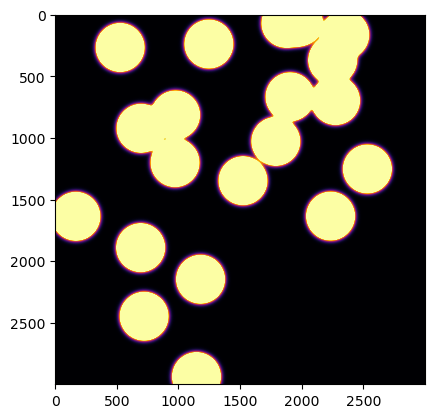

In [ ]:
plt.imshow(np.sum(image, axis=2), vmin=0, vmax=3000, cmap='inferno')

In [77]:
norm_data = data/np.sum(data)

In [84]:
np.sum(image, axis=2)*10e40

array([[8.64067324e+004, 1.06697243e+005, 1.31699793e+005, ...,
        3.36088967e-004, 2.59265159e-004, 1.99921888e-004],
       [9.62760230e+004, 1.18884095e+005, 1.46742412e+005, ...,
        3.59493588e-004, 2.77319911e-004, 2.13844082e-004],
       [1.07229674e+005, 1.32409943e+005, 1.63437796e+005, ...,
        3.84374283e-004, 2.96513333e-004, 2.28644317e-004],
       ...,
       [1.66069598e-036, 2.21635925e-036, 2.95676262e-036, ...,
        2.79933577e-176, 2.06245783e-176, 1.51894289e-176],
       [1.33400389e-036, 1.78035708e-036, 2.37510831e-036, ...,
        1.62498469e-176, 1.19723487e-176, 8.81730221e-177],
       [1.07115012e-036, 1.42955332e-036, 1.90711404e-036, ...,
        9.42909120e-177, 6.94704195e-177, 5.11630338e-177]])

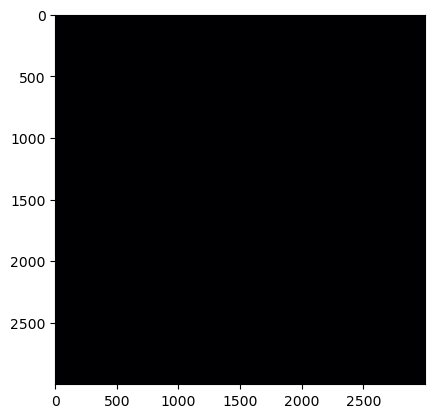

In [ ]:
plt.imshow(norm_data-np.sum(image, axis=2), vmin=0, vmax=300, cmap='inferno')

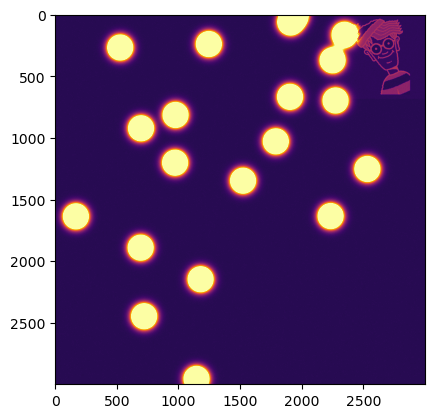

In [85]:
plt.imshow(data-np.sum(image, axis=2), vmin=0, vmax=700, cmap='inferno')

In [95]:
import starsub
# reload starsub
import importlib
importlib.reload(starsub)

image = starsub.make_psf_image(data, mean_x, mean_y, 5)*1e4

In [97]:
np.mean(np.sum(image, axis=2))

0.8696533006328292

In [98]:
np.mean(data)

10.513117944027913

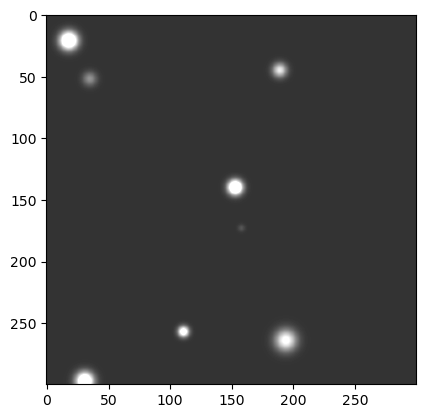

In [99]:
plt.imshow(data,cmap='gray', vmin=0, vmax=50)

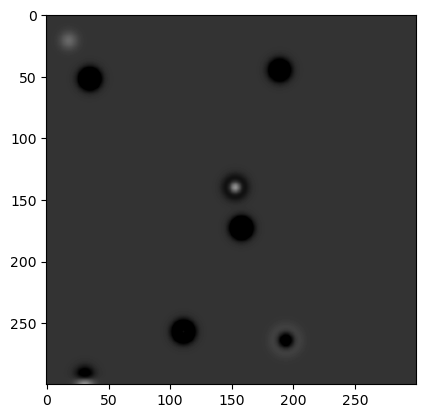

In [100]:
plt.imshow(data-np.sum(image, axis=2), cmap='gray', vmin=0, vmax=50)

In [ ]:
def average_peaks(peak_x_values, peak_y_values):
    nearest_pixel_x = []
    nearest_pixel_y = []

    distance_value =[]

    lone_pixel_x = [
    ]
    lone_pixel_y = []
    
    peak_positions = np.stack((peak_x_values, peak_y_values), axis=-1)
    for pos in peak_positions:
        distances = np.sqrt(np.sum((peak_positions - pos) ** 2, axis=1))
        nearest_index = np.argsort(distances)[1]  # Skip the first (self)
        nearest_pixel_x.append(peak_x_values[nearest_index])
        nearest_pixel_y.append(peak_y_values[nearest_index])
        distance_value.append(distances[nearest_index])
        if (distances[nearest_index]) > 3:
            lone_pixel_x.append(peak_positions[0])
            lone_pixel_y.append(peak_positions[1])

    
    return np.array(nearest_pixel_x), np.array(nearest_pixel_y), lone_pixel_x, lone_pixel_y, distance_value



In [ ]:
peak_positions = np.stack((peak_x_values, peak_y_values), axis=-1)
distances=np.sqrt(np.sum((peak_positions - peak_positions[20]) ** 2, axis=1))
distances

0.0

In [71]:
nearest_index = np.argsort(distances)
for k in distances[nearest_index]:
    print(k)

0.0
1.0
1.0
1.4142135623730951
2.0
2.0
2.23606797749979
2.23606797749979
2.23606797749979
2.23606797749979
2.8284271247461903
3.0
3.0
3.1622776601683795
3.1622776601683795
3.1622776601683795
3.1622776601683795
3.605551275463989
3.605551275463989
4.0
4.0
4.123105625617661
4.123105625617661
4.123105625617661
4.123105625617661
4.242640687119285
4.47213595499958
4.47213595499958
4.47213595499958
4.47213595499958
5.0
5.0
5.0
5.0
5.0990195135927845
5.0990195135927845
5.0990195135927845
5.0990195135927845
5.385164807134504
5.385164807134504
5.385164807134504
5.385164807134504
5.656854249492381
5.830951894845301
5.830951894845301
6.0
6.0
6.082762530298219
6.082762530298219
6.082762530298219
6.082762530298219
6.324555320336759
6.324555320336759
6.324555320336759
6.324555320336759
6.4031242374328485
6.4031242374328485
6.708203932499369
6.708203932499369
7.0
7.0
7.0710678118654755
7.0710678118654755
7.0710678118654755
7.0710678118654755
7.0710678118654755
7.211102550927978
7.211102550927978
7.280

In [55]:
distances

array([  1.        ,   0.        ,   1.        , ..., 988.0713537 ,
       987.952428  , 987.83450031])

In [44]:
xs, xy, lx, ly, d = average_peaks(peak_x_values, peak_y_values)

In [45]:
print(d)

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,